# BYOL Merger Classification Analysis

Clean, refactored notebook for analyzing BYOL embeddings and classifying galaxy mergers.

This notebook:
1. Loads trained BYOL model and embeddings
2. Applies PCA and UMAP dimensionality reduction
3. Performs K-NN based label propagation
4. Identifies merger candidates
5. Creates visualizations and analysis plots

## Setup and Imports

In [ ]:
import os
os.chdir('/Users/kadofong/work/projects/merian/pieridae/merger_analysis/notebooks')

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add pieridae to path
sys.path.insert(0, str(Path.cwd().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import pickle
from tqdm import tqdm

from pieridae.starbursts.byol import (
    BYOLModelManager,
    EmbeddingAnalyzer,
    LabelPropagation,
    load_merian_images
)

# Plotting utilities
from ekfplot import plot as ek, colors as ec
from matplotlib import colors

print("✅ Imports complete")

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


✅ Imports complete


## Load Configuration

In [2]:
# Load config
config_path = '../config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

config['data']['input_path'] = Path(config['data']['input_path'])
config['data']['output_path'] = Path(config['data']['output_path'])

print(f"📋 Configuration loaded")
print(f"   Input: {config['data']['input_path']}")
print(f"   Output: {config['data']['output_path']}")

📋 Configuration loaded
   Input: ../../local_data/pieridae_output/starlet/msorabove_v0
   Output: ../output


## Load Data and Embeddings

In [3]:
# Load images
print("Loading images...")
images, img_names = load_merian_images(config['data']['input_path'])
print(f"✅ Loaded {len(images)} images with shape {images.shape}")

Loading images...


Found 22913 image files
Counting valid images...
Validating files: 100%|██████████████| 22913/22913 [00:00<00:00, 87788.98it/s]
Found 22913 valid image sets
Loading images: 100%|██████████████████| 22913/22913 [00:37<00:00, 608.93it/s]
Loaded 22913 images with shape: (22913, 3, 150, 150)


✅ Loaded 22913 images with shape (22913, 3, 150, 150)


In [4]:
# Load or extract embeddings
output_path = config['data']['output_path']
embeddings_file = output_path / 'embeddings.npy'

if embeddings_file.exists():
    print("Loading existing embeddings...")
    embeddings = np.load(embeddings_file)
else:
    print("Extracting embeddings from trained model...")
    model_manager = BYOLModelManager(config, output_path)
    embeddings = model_manager.extract_embeddings(images)

print(f"✅ Embeddings shape: {embeddings.shape}")

Loading existing embeddings...
✅ Embeddings shape: (22913, 512)


## Dimensionality Reduction

In [5]:
# Compute PCA
print("Computing PCA...")
analyzer = EmbeddingAnalyzer(config)
embeddings_pca = analyzer.compute_pca(embeddings)

explained_var = analyzer.pca.explained_variance_ratio_.sum() * 100
print(f"✅ PCA complete: {analyzer.pca.n_components_} components")
print(f"   Explained variance: {explained_var:.1f}%")

2025-10-14 11:52:57,897 - INFO - Computing PCA...


Computing PCA...


2025-10-14 11:52:58,115 - INFO - PCA components: 10
2025-10-14 11:52:58,115 - INFO - Explained variance: 86.0%


✅ PCA complete: 10 components
   Explained variance: 86.0%


In [6]:
# Compute UMAP
print("Computing UMAP...")
embeddings_umap = analyzer.compute_umap(embeddings_pca)
print(f"✅ UMAP complete: shape {embeddings_umap.shape}")

2025-10-14 11:52:58,155 - INFO - Computing UMAP...
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP...
UMAP(min_dist=0.01, n_jobs=1, random_state=42, verbose=True)
Tue Oct 14 11:52:58 2025 Construct fuzzy simplicial set
Tue Oct 14 11:52:58 2025 Finding Nearest Neighbors
Tue Oct 14 11:52:58 2025 Building RP forest with 13 trees
Tue Oct 14 11:53:01 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Tue Oct 14 11:53:05 2025 Finished Nearest Neighbor Search
Tue Oct 14 11:53:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


2025-10-14 11:53:16,123 - INFO - UMAP embedding shape: (22913, 2)


Tue Oct 14 11:53:16 2025 Finished embedding
✅ UMAP complete: shape (22913, 2)


## Load Classification Labels

In [7]:
# Load labels
label_file = Path(config.get('labels', {}).get('classifications_file', ''))

if label_file.exists():
    mergers = pd.read_csv(label_file, index_col=0)
    labels = mergers.reindex(img_names)
    labels = labels.replace(np.nan, 0).values.flatten().astype(int)
    
    print(f"✅ Loaded {len(labels)} labels")
    
    # Print distribution
    label_meanings = config.get('labels', {}).get('label_mapping', {})
    unique, counts = np.unique(labels, return_counts=True)
    
    print("\n📊 Label distribution:")
    for label_val, count in zip(unique, counts):
        meaning = label_meanings.get(label_val, f"unknown_{label_val}")
        print(f"   {label_val} ({meaning}): {count} objects")
else:
    print(f"⚠️  Label file not found: {label_file}")
    labels = np.zeros(len(img_names), dtype=int)

✅ Loaded 22913 labels

📊 Label distribution:
   0 (unclassified): 19960 objects
   1 (undisturbed): 2314 objects
   2 (ambiguous): 214 objects
   3 (merger): 96 objects
   4 (fragmentation): 280 objects
   5 (artifact): 49 objects


## K-NN Label Propagation

In [9]:
# Initialize label propagation
n_min = config.get('labels', {}).get('minimum_labeled_neighbors', 5)
n_min_auto = config.get('labels', {}).get('minimum_labeled_neighbors_for_autoprop', 15)
print(f"Using minimum_labeled_neighbors_for_autoprop = {n_min_auto}")

print(f"Using minimum_labeled_neighbors = {n_min}")

propagator = LabelPropagation(
    n_neighbors=50,
    n_min=n_min,
    n_min_auto=n_min_auto,
    prob_threshold=0.9,
    frag_threshold=0.1,
)

# Run iterative propagation
print("\nRunning iterative label propagation...")
iterative_labels, n_labels_iter, prob_labels_iter, stats = \
    propagator.iterative_propagation(embeddings_pca, labels)

print(f"\n✅ Label propagation complete")
print(f"   Human labels: {stats['n_human']}")
print(f"   Auto-labels added: {stats['n_added_iteration']}")
print(f"   Total labels: {stats['n_final_auto']}")

2025-10-14 11:53:16,290 - INFO - 
Starting iterative label estimation...
2025-10-14 11:53:16,291 - INFO - Finding 50 nearest neighbors...


Using minimum_labeled_neighbors_for_autoprop = 15
Using minimum_labeled_neighbors = 5

Running iterative label propagation...


2025-10-14 11:53:17,650 - INFO - Human labels: 2953
/Users/kadofong/work/projects/merian/pieridae/pieridae/starbursts/byol.py:698: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)
2025-10-14 11:53:17,673 - INFO - 15493 objects have auto-labels
2025-10-14 11:53:17,674 - INFO - 7420 objects have fewer than 5 labeled neighbors
2025-10-14 11:53:17,675 - INFO - Initial auto-labels: 15493 objects have potential probabilistic labels
2025-10-14 11:53:17,675 - INFO - Added 311 auto-labels in first iteration
2025-10-14 11:53:17,676 - INFO - Total labels after iteration: 3264
2025-10-14 11:53:17,676 - INFO - 
Recalculating with expanded label set...
2025-10-14 11:53:17,700 - INFO - 17059 objects have auto-labels
2025-10-14 11:53:17,701 - INFO - 5854 objects have fewer than 5 labeled neighbors
2025-10-14 11:53:17,702 - INFO - After second iteration: 17059 objects have auto-labels



✅ Label propagation complete
   Human labels: 2953
   Auto-labels added: 311
   Total labels: 17059


## Identify Merger Candidates

In [10]:
# Identify mergers based on probability labels
fragmented = prob_labels_iter[:, 4] > 0.3
possible_merger = (prob_labels_iter[:, 2] + prob_labels_iter[:, 3]) > prob_labels_iter[:, 1]

is_merger = possible_merger & ~fragmented

print(f"📊 Merger identification:")
print(f"   Fragmented objects: {fragmented.sum()}")
print(f"   Possible mergers: {possible_merger.sum()}")
print(f"   Merger candidates (excluding fragmented): {is_merger.sum()}")

📊 Merger identification:
   Fragmented objects: 1795
   Possible mergers: 1283
   Merger candidates (excluding fragmented): 556


## Visualizations

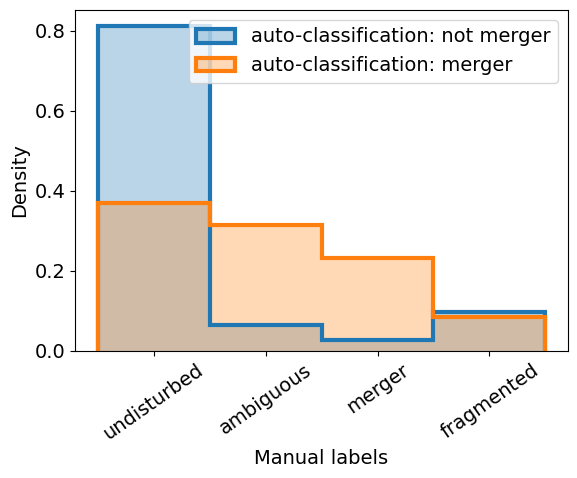

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

# Compare with manual labels
if (labels > 0).any():
    
    
    # Create contingency table
    manual_merger = (labels == 3) | (labels == 2)  # merger or ambiguous
    manual_nonmerger = labels == 1  # undisturbed
    
    hist_kwargs = {'alpha': 0.3, 'lw': 3, 'bins': np.arange(0.5, 5.5), 'density': True}
    
    ek.hist(labels[~is_merger], ax=ax, label='auto-classification: not merger', **hist_kwargs)
    ek.hist(labels[is_merger], ax=ax, label='auto-classification: merger', **hist_kwargs)
    
    ax.set_xticks(np.arange(1,5),['undisturbed', 'ambiguous', 'merger', 'fragmented'], rotation=35)
    ax.set_xlabel('Manual labels')
    ax.set_ylabel('Density')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

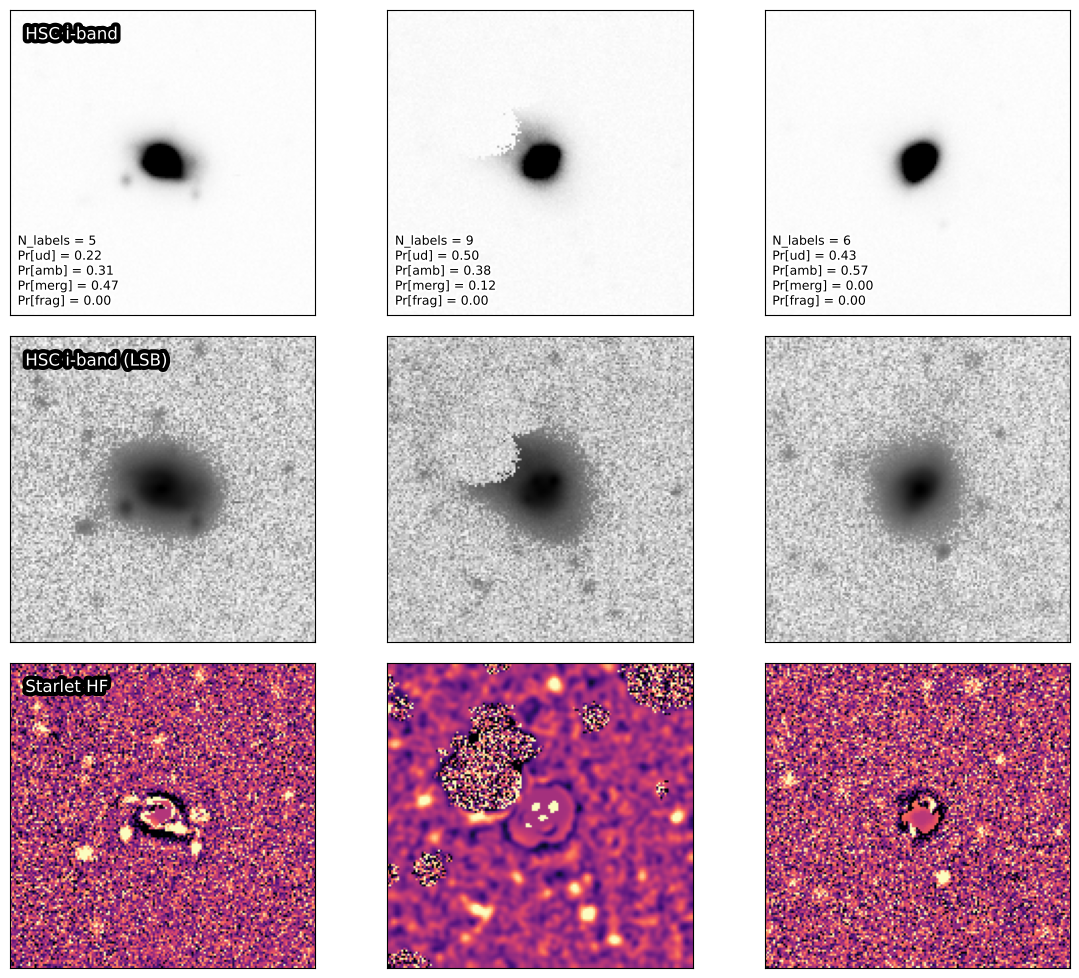

In [49]:
# Show examples of merger candidates
candidates = np.arange(len(img_names))[possible_merger & ~fragmented & manual_nonmerger]
n_examples = min(3, len(candidates))

if n_examples > 0:
    example_indices = np.random.choice(candidates, n_examples, replace=False)
    
    fig, axarr = plt.subplots(3, n_examples, figsize=(12, 10))
    
    for idx, gix in enumerate(example_indices):
        # i-band
        ek.imshow(images[gix][1], ax=axarr[0, idx], q=0.01, cmap='Greys')
        
        # i-band log scale
        axarr[1, idx].imshow(
            images[gix][1],
            origin='lower',
            cmap='Greys',
            norm=colors.SymLogNorm(linthresh=0.1)
        )
        
        # High-frequency
        ek.imshow(images[gix][2], ax=axarr[2, idx], cmap='magma')
        
        # Add statistics
        ek.text(
            0.025, 0.025,
            f"""N_labels = {n_labels_iter[gix]}
Pr[ud] = {prob_labels_iter[gix, 1]:.2f}
Pr[amb] = {prob_labels_iter[gix, 2]:.2f}
Pr[merg] = {prob_labels_iter[gix, 3]:.2f}
Pr[frag] = {prob_labels_iter[gix, 4]:.2f}""",
            ax=axarr[0, idx],
            fontsize=9,
            bordercolor='w',
            color='k',
            borderwidth=3
        )
    
    for ax in axarr.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    ek.text(0.05, 0.95, 'HSC i-band', ax=axarr[0, 0], fontsize=12, 
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'HSC i-band (LSB)', ax=axarr[1, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'Starlet HF', ax=axarr[2, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    
    plt.tight_layout()
else:
    print("No merger classification conflicts found")

## Example Merger Candidates

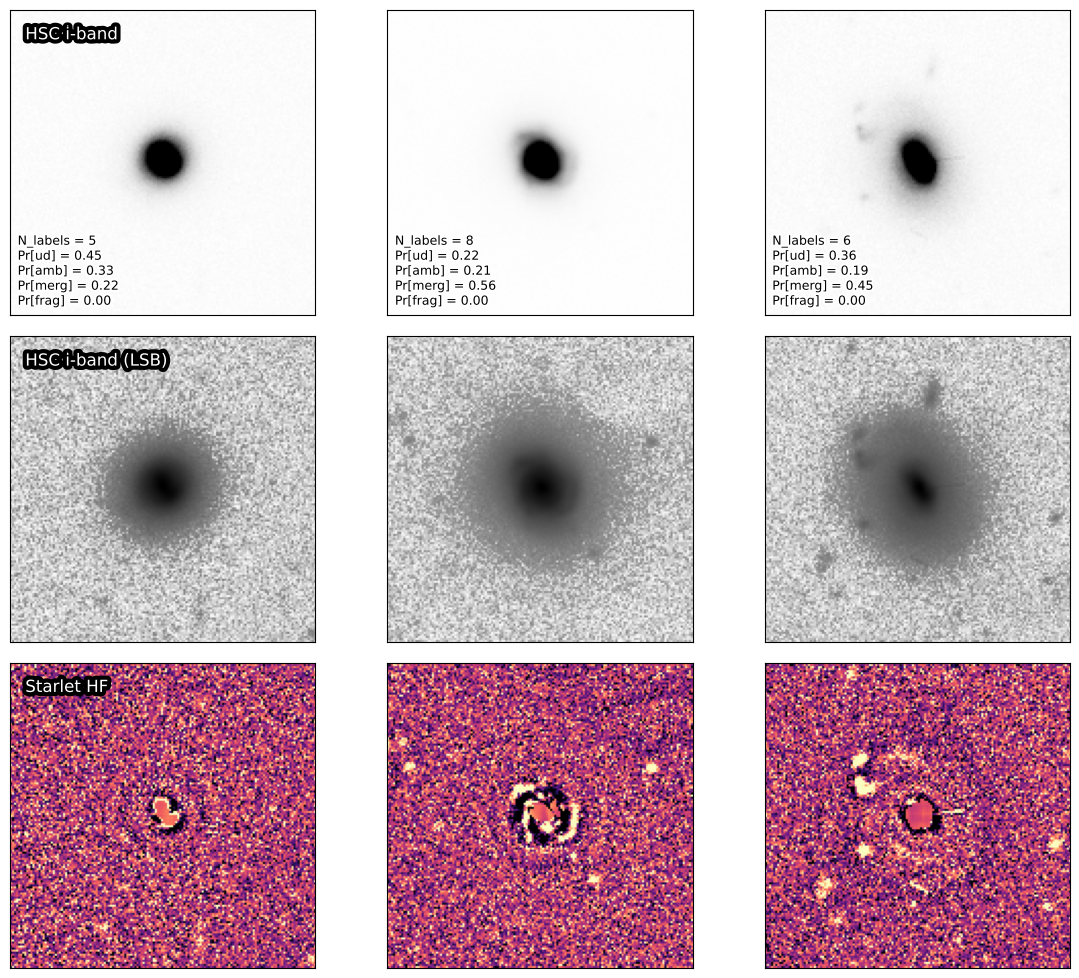

In [34]:
# Show examples of merger candidates
candidates = np.arange(len(img_names))[possible_merger & ~fragmented]
n_examples = min(3, len(candidates))

if n_examples > 0:
    example_indices = np.random.choice(candidates, n_examples, replace=False)
    
    fig, axarr = plt.subplots(3, n_examples, figsize=(12, 10))
    
    for idx, gix in enumerate(example_indices):
        # i-band
        ek.imshow(images[gix][1], ax=axarr[0, idx], q=0.01, cmap='Greys')
        
        # i-band log scale
        axarr[1, idx].imshow(
            images[gix][1],
            origin='lower',
            cmap='Greys',
            norm=colors.SymLogNorm(linthresh=0.1)
        )
        
        # High-frequency
        ek.imshow(images[gix][2], ax=axarr[2, idx], cmap='magma')
        
        # Add statistics
        ek.text(
            0.025, 0.025,
            f"""N_labels = {n_labels_iter[gix]}
Pr[ud] = {prob_labels_iter[gix, 1]:.2f}
Pr[amb] = {prob_labels_iter[gix, 2]:.2f}
Pr[merg] = {prob_labels_iter[gix, 3]:.2f}
Pr[frag] = {prob_labels_iter[gix, 4]:.2f}""",
            ax=axarr[0, idx],
            fontsize=9,
            bordercolor='w',
            color='k',
            borderwidth=3
        )
    
    for ax in axarr.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    ek.text(0.05, 0.95, 'HSC i-band', ax=axarr[0, 0], fontsize=12, 
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'HSC i-band (LSB)', ax=axarr[1, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'Starlet HF', ax=axarr[2, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    
    plt.tight_layout()
    plt.show()
else:
    print("No merger candidates found")

# Distance off MS

In [50]:
from ekfplot import colors as ec, plot as ek
from ekfphys import calibrations
from pieridae.starbursts import sample

In [55]:
prob_labels_iter.shape

(22913, 6)

In [58]:
full_catalog, masks = sample.load_sample(
    '/Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet'
)
base_catalog = full_catalog.loc[masks['is_good'][0]]

datadir = '../../local_data/pieridae_output/starlet/msorabove_v0/'
for sid in tqdm(base_catalog.index):
    filename = f'{datadir}/{sid}/{sid}_i_results.pkl'
    if not os.path.exists(filename):
        continue
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    base_catalog.loc[sid, 'logmass_adjusted'] = x['logmass_adjusted']
base_catalog.loc[base_catalog['logmass_adjusted'].isna(),'logmass_adjusted'] = base_catalog.loc[base_catalog['logmass'].isna(),'logmass_adjusted']

fragmented = prob_labels_iter[:,4] > 0.3
prob_merger = (prob_labels_iter[:,2]+prob_labels_iter[:,3]) > prob_labels_iter[:,1]

catalog = base_catalog.reindex(img_names[~fragmented])
catalog['p_merger'] = np.where((prob_labels_iter[~fragmented]==0).all(axis=1), np.nan, prob_labels_iter[~fragmented,3])
catalog['p_ambig'] = np.where((prob_labels_iter[~fragmented]==0).all(axis=1), np.nan, prob_labels_iter[~fragmented,2])
catalog['p_undisturbed'] = np.where((prob_labels_iter[~fragmented]==0).all(axis=1), np.nan, prob_labels_iter[~fragmented,1])

dm = catalog['logmass_adjusted'] - catalog['logmass']
catalog = catalog.loc[dm < 0.5]

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.6 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Computed internal extinction corrections in 0.6 seconds.


  0%|                                               | 0/47346 [00:00<?, ?it/s]/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_32571/1880937884.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_catalog.loc[sid, 'logmass_adjusted'] = x['logmass_adjusted']
100%|█████████████████████████████████| 47346/47346 [00:19<00:00, 2489.03it/s]


/Users/kadofong/work/ekfutils/ekfplot/ekfplot/plot.py:494: RuntimeWarning: invalid value encountered in divide
  im=ax.pcolormesh(bins[0], bins[1], (weighted_counts/raw_counts).T, cmap=cmap, **kwargs)


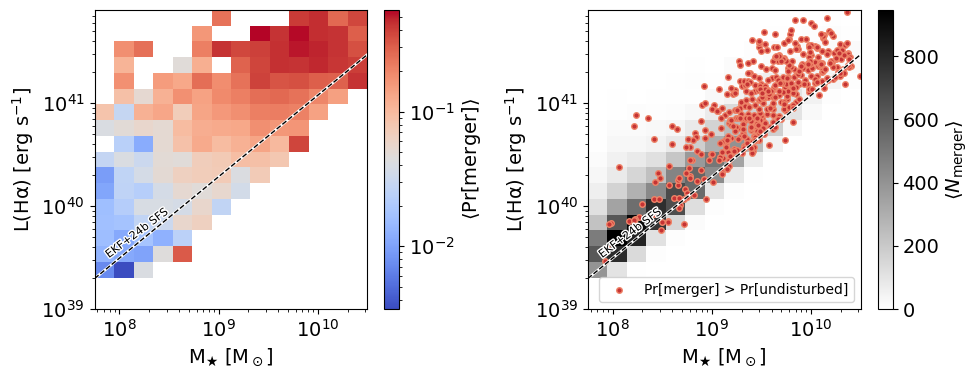

In [59]:
fig, axarr = plt.subplots(1,2,figsize=(10,4))

bins = [np.logspace(7.75, 10.5,15), np.logspace(39,41.9,20)]
im,_=ek.pcolor_avg2d(
    10.**catalog['logmass_adjusted'], 
    catalog['L_Ha'],
    catalog['p_merger']+catalog['p_ambig'],
    cmap='coolwarm',
    yscale='log',
    xscale='log',
    zscale='log',
    bins=bins,
    ax=axarr[0],
    #vmax=0.35,
    #vmin=0.01
    #s=3,
    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
)

imx=ek.hist2d(
    10.**catalog['logmass_adjusted'], 
    catalog['L_Ha'],
    cmap=ec.ColorBase('k').sequential_cmap(fade=1.),
    yscale='log',
    xscale='log',
    #zscale='log',
    bins=bins,
    ax=axarr[1],
    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
)

#imx=ek.hist2d(
#    10.**catalog['logmass_adjusted'], 
#    catalog['L_Ha'],
#    weights=np.where(np.isnan(catalog['p_merger']+catalog['p_ambig']),0., catalog['p_merger']+catalog['p_ambig']),
#    cmap=ec.ColorBase('tab:red').sequential_cmap(fade=0.),
#    yscale='log',
#    xscale='log',
#    #zscale='log',
#    bins=bins,
#    ax=axarr[1],
#    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
#)
probable_merger = (catalog['p_ambig']+catalog['p_merger'])>catalog['p_undisturbed']
axarr[1].scatter(
    10.**catalog.loc[probable_merger,'logmass_adjusted'], 
    catalog.loc[probable_merger, 'L_Ha'],
    fc=plt.cm.coolwarm(.95),
    ec=plt.cm.coolwarm(0.8),
    s=4**2,
    label=r'Pr[merger] > Pr[undisturbed]'
)
axarr[1].legend(loc='lower right', fontsize=10)

ms = im._coordinates.data[0,:,0]
alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs = 10.**(alpha*(np.log10(ms) - 8.5) + norm)
ha_sfs = calibrations.SFR2LHa(sfs)
plt.colorbar(imx[0][-1],ax=axarr[1], label=r'$\langle N_{\rm merger} \rangle$')
plt.colorbar(im,ax=axarr[0], label=r'$\langle {\rm Pr[merger]}\rangle$')

for ax in axarr:
    ek.outlined_plot(
        ms,
        ha_sfs,
        ax=ax,
        lw=1,
        ls='--',
    )
    
    ek.text(
        7e7,
        3e39,
        'EKF+24b SFS',
        ax=ax,
        rotation=37,
        coord_type='absolute',
        va='bottom',
        ha='left',
        bordercolor='w',
        borderwidth=2,
        fontsize=8,        
    )    
    ax.set_xlabel(ek.common_labels['mstar'])
    ax.set_ylabel(ek.common_labels['halum'])
    ek.loglog(ax=ax)

#prob_merger = (catalog['p_merger']+catalog['p_ambig']) > catalog['p_undisturbed']
#axarr[0].scatter(
#    10.**catalog.loc[prob_merger, 'logmass_adjusted'],
#    catalog.loc[prob_merger, 'L_Ha'],
#    color='lime'
#)
plt.tight_layout ()
plt.savefig('/Users/kadofong/work/papers/journal/MerianStarbursts/figures/pmerger_sfs.pdf')

/Users/kadofong/work/ekfutils/ekfstats/ekfstats/sampling.py:949: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_x = x[sortmask]
        Use astropy.stats.knuth_bin_width instead. [warnings]


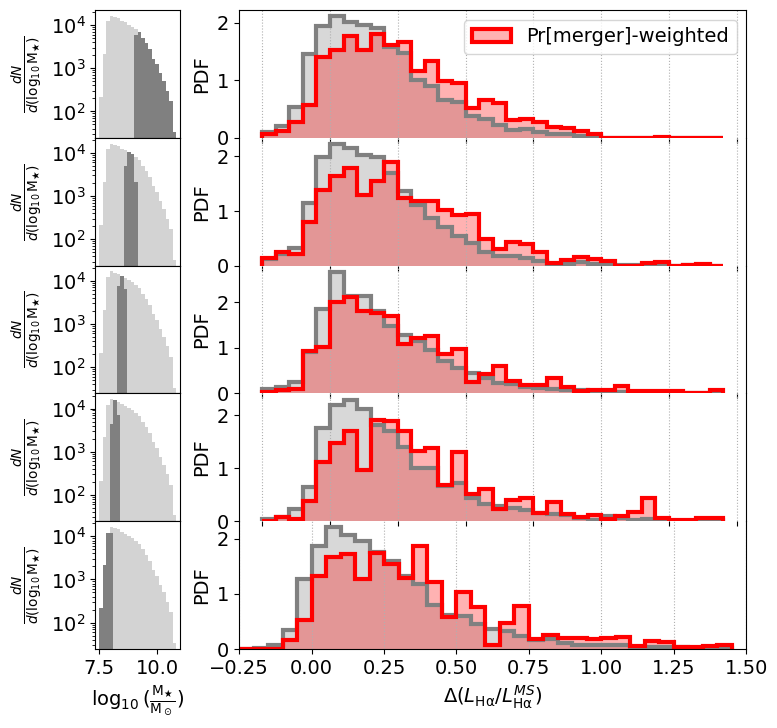

In [60]:
from ekfstats import sampling

from astroML.density_estimation import knuth_bin_width

def gotoscinot(value):
    power = int(np.floor(value))
    leading = 10.**(value - np.floor(value))
    return rf'{leading:.0f}$\times10^{{{power}}}$'

alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs_at_mass = 10.**(alpha*(catalog['logmass_adjusted'] - 8.5) + norm)
ha_sfs_at_mass = calibrations.SFR2LHa(sfs_at_mass)
mbins = np.arange(7.5, 10.8,0.15)

groups, logmstar_bins = sampling.bin_by_count(catalog['logmass_adjusted'], 4000, dx_min=0.1)

groupids = np.unique(groups,)
ngroups = groupids.size
fig, f_axarr = plt.subplots(ngroups, 2, figsize=(8,1.5*ngroups), gridspec_kw={'width_ratios':(1,6)})
axarr = f_axarr[:,1]

for idx,gid in enumerate(groupids[::-1]):
    #ms_at_mass = np.interp( 0.5*(logmstar_bins[gid-1]+logmstar_bins[gid]), np.log10(ms), np.log10(ha_sfs) )
    ms_at_mass = np.interp ( catalog.loc[groups==gid, 'logmass_adjusted'], np.log10(ms), np.log10(ha_sfs) )
    dx,bins = knuth_bin_width(np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, return_bins=True)
    hkwargs = {'alpha':.3,'lw':3, 'bins':np.arange(-0.25,1.5, 0.05), 'density':True, 'ax':axarr[idx]}
    
    logmbounds = logmstar_bins[gid-1], logmstar_bins[gid]
    
    pmerger = catalog['p_merger']+catalog['p_ambig']
    bkgcolor = ec.ColorBase('grey')#.modulate(0.1, -0.4)
    
    ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, color=bkgcolor.base, **hkwargs)
    ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, color='r', label='Pr[merger]-weighted',
             weights=pmerger.loc[groups==gid], **hkwargs)
    #ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, 
    #         weights=np.where(pmerger>0.25,1.,0.)[groups==gid], **hkwargs)

    dm = np.diff(mbins)[0]
    ek.hist(catalog['logmass_adjusted'], bins=mbins, weights=np.full(len(catalog), 1./dm), ax=f_axarr[idx, 0], color='lightgrey')

    mmask = (catalog['logmass_adjusted']>logmbounds[0])&(catalog['logmass_adjusted']<=logmbounds[1])
    ek.hist(catalog.loc[mmask,'logmass_adjusted'], color=bkgcolor.base, ax=f_axarr[idx,0], bins=mbins, weights=np.full(mmask.sum(),1./dm))
axarr[0].legend(loc='upper right')
plt.xlim(-0.25,1.5)
axarr[-1].set_xlabel(r'$\Delta (L_{\rm H\alpha}/L_{\rm H\alpha}^{MS})$')
for ax in axarr:
    #ax.set_ylabel('PD)
    ax.set_facecolor((1, 1, 1, 0))
    ax.grid('lightgrey', ls=':', axis='x', which='both')
    ax.set_ylabel('PDF')
    #ax.set_yticks([])
for ax in axarr[1:]:
    ax.spines[['top']].set_visible(False)
for ax in axarr[:-1]:
    ax.spines[['bottom']].set_visible(False)    
    ax.set_xticklabels([])
for ax in f_axarr[:,0]:    
    #ax.set_yticks([])
    ax.set_yscale('log')
    ax.set_ylabel(r'$\frac{dN}{d(\log_{10} \rm M_\bigstar)}$')
for ax in f_axarr[:-1,0]:
    ax.set_xticks([])
f_axarr[-1,0].set_xlabel(r'$\log_{10} (\frac{\rm M_\bigstar}{M_\odot})$')

plt.tight_layout ()
plt.subplots_adjust(hspace=0., wspace=0.2)

plt.savefig('/Users/kadofong/work/papers/journal/MerianStarbursts/figures/lha_ms_pdfs.pdf', bbox_inches='tight')

In [88]:

alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs_at_mass = 10.**(alpha*(catalog['logmass_adjusted'] - 8.5) + norm)
ha_sfs_at_mass = calibrations.SFR2LHa(sfs_at_mass)

In [136]:
vals.loc[ngal<50]

6   NaN
7   NaN
8   NaN
9   NaN
dtype: float64

In [1]:
fig, axarr = plt.subplots(1,2,figsize=(12,5))

loglhabins = np.arange(0.,2.5, 0.25) 

groups, logmstar_bins = sampling.bin_by_count(catalog['logmass_adjusted'], 4000, dx_min=0.1)

groupids = np.unique(groups,)

for idx,gid in enumerate(groupids):
    ngal = (groups==gid).sum()

    nmc = 100
    xs = sampling.midpts(loglhabins)
    yarr = np.zeros([nmc, xs.size])
    for _ in range(nmc):
        selected = catalog.loc[groups==gid].iloc[np.random.randint(0, ngal, ngal)]
        ms_at_mass = np.interp ( selected['logmass_adjusted'], np.log10(ms), np.log10(ha_sfs) )
        assns = np.digitize(np.log10(selected['L_Ha']) - ms_at_mass, loglhabins)
    
        vals = pmerger.reindex(selected.index).groupby(assns)
        yarr[_] = np.nan
        yarr[_,vals.mean().index] = np.where(vals.count()>10, vals.mean().values, np.nan)

    
    for idx,is_normalized in enumerate([False,True]):
        mask = np.isfinite(yarr).any(axis=0)

        ys = np.nanmedian(yarr,axis=0)[mask]
        ys_low = np.nanquantile(yarr,0.16,axis=0)[mask]
        ys_high = np.nanquantile(yarr,0.84,axis=0)[mask]
        if is_normalized:
            ys_low /= ys[0]
            ys_high /= ys[0]
            ys /= ys[0]
            
        
        ek.outlined_plot(
            xs[mask],
            ys,
            lw=1,
            ax=axarr[idx]
        )
        axarr[idx].fill_between(
            xs[mask],
            ys_low,
            ys_high,        
            label=f'[{logmstar_bins[gid-1]:.2f},{logmstar_bins[gid]:.2f}]',
            alpha=0.3,
        )
plt.legend()

for ax in axarr:
    ax.set_xlabel(r'$\log_{10}(L_{\rm H\alpha}/L_{\rm H\alpha}^{\rm SFS})$')
axarr[0].set_ylabel(r'$\langle \rm Pr[merger] \rangle$')
axarr[1].set_ylabel(r'$\langle \rm Pr[merger]/Pr[merger|SFS] \rangle$')

plt.savefig('/Users/kadofong/Downloads/pmerge_v_mass.pdf')

NameError: name 'plt' is not defined

In [149]:
from astropy import coordinates, units as u
from astropy import cosmology 
from ekfstats import galstats
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [309]:
massive_galaxies = base_catalog.query('logmass_adjusted>10.')
mcoords = coordinates.SkyCoord(massive_galaxies['RA'],massive_galaxies['DEC'], unit='deg')
tcoords = coordinates.SkyCoord(catalog['RA'], catalog['DEC'], unit='deg')

nmc = 100

p_environment = np.zeros([nmc, len(catalog), 3])
for _ in tqdm(range(nmc)):
    #catalog['z'] = np.where(np.isnan(catalog['z_spec']), np.random.uniform(0.06, 0.1, len(catalog)), catalog['z_spec'])
    #massive_galaxies['z'] =  np.where(np.isnan(massive_galaxies['z_spec']), np.random.uniform(0.06, 0.1, len(massive_galaxies)), massive_galaxies['z_spec']) 
    catalog['z'] = np.where(np.isnan(catalog['z_spec']), 300., catalog['z_spec'])
    massive_galaxies['z'] =  np.where(np.isnan(massive_galaxies['z_spec']), 300., massive_galaxies['z_spec'])     
    envdict = galstats.classify_environment_fast(catalog, massive_galaxies, return_separations=False, verbose=0, vdiff_max_satellite=1000.)
    has_specz = np.isfinite(catalog['z_spec'])
    p_environment[_,:,0] = np.where(has_specz, envdict['satellite'], 0)
    p_environment[_,:,1] = np.where(has_specz, envdict['central'], 0)
    p_environment[_,:,2] = np.where(has_specz, envdict['isolated'], 0)

  0%|                                                 | 0/100 [00:00<?, ?it/s]/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_32571/1390575908.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  massive_galaxies['z'] =  np.where(np.isnan(massive_galaxies['z_spec']), 300., massive_galaxies['z_spec'])
100%|███████████████████████████████████████| 100/100 [00:17<00:00,  5.77it/s]


In [314]:
p_environment[0,:,0].sum()

152.0

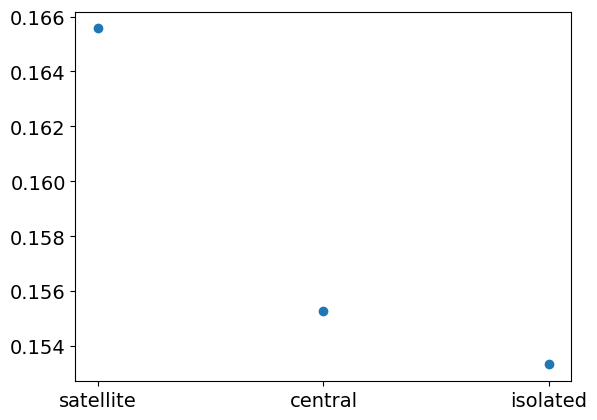

In [310]:
pmerger = catalog.loc[:, 'p_merger'] + catalog.loc[:, 'p_ambig']

pm_avg = np.array([ np.nansum(pmerger.values*p_environment[:,:,ix], axis=1) / np.nansum(np.isfinite(pmerger.values)*p_environment[:,:,ix],axis=1) for \
                ix in range(3) ])

ax = plt.subplot(111)
ek.errorbar(
    np.arange(3),
    np.median(pm_avg,axis=1),
    ylow=np.quantile(pm_avg, 0.16, axis=1),
    yhigh=np.quantile(pm_avg, 0.84, axis=1),
    capsize=3
)
ax.set_xticks([0,1,2], ['satellite','central','isolated'])

In [311]:
selected = catalog.loc[p_environment[_,:,0]==1]

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_32571/2231416968.py:32: RuntimeWarning: All-NaN slice encountered
  ys = np.nanmedian(yarr,axis=0)[mask]


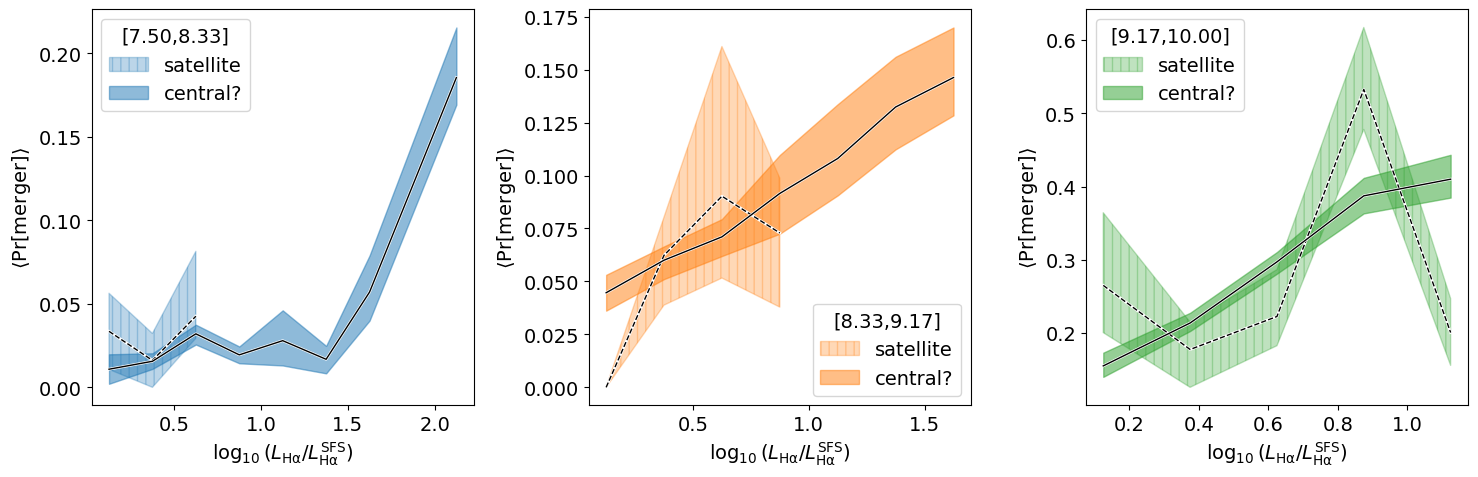

In [324]:
fig, axarr = plt.subplots(1,3,figsize=(15,5))

loglhabins = np.arange(0.,2.5, 0.25) 

#groups, logmstar_bins = sampling.bin_by_count(catalog['logmass_adjusted'], 6000, dx_min=0.1)
logmstar_bins = np.linspace(7.5, 10., 4)
groups = np.digitize(catalog['logmass_adjusted'], logmstar_bins)

groupids = np.unique(groups,)
groupids = groupids[(groupids>0)&(groupids<len(logmstar_bins))]

ls_l = ['--','-',':']
for envkey in [0,1]:
    for gidx,gid in enumerate(groupids):
        ngal = (groups==gid).sum()
    
        nmc = 100
        xs = sampling.midpts(loglhabins)
        yarr = np.zeros([nmc, xs.size])
        for _ in range(nmc):
            selected = catalog.loc[(groups==gid)&(p_environment[_,:,envkey]==1)]
            selected = selected.iloc[np.random.randint(0, len(selected), len(selected))]
            ms_at_mass = np.interp ( selected['logmass_adjusted'], np.log10(ms), np.log10(ha_sfs) )
            assns = np.digitize(np.log10(selected['L_Ha']) - ms_at_mass, loglhabins)
        
            vals = pmerger.reindex(selected.index).groupby(assns)
            yarr[_] = np.nan
            yarr[_,vals.mean().index] = np.where(vals.count()>5, vals.mean().values, np.nan)
    
        mask = np.isfinite(yarr).any(axis=0)

        ys = np.nanmedian(yarr,axis=0)[mask]
        ys_low = np.nanquantile(yarr,0.16,axis=0)[mask]
        ys_high = np.nanquantile(yarr,0.84,axis=0)[mask]
            
        
        ek.outlined_plot(
            xs[mask],
            ys,
            lw=1,
            ax=axarr[gidx],
            ls=ls_l[envkey],
        )
        axarr[gidx].fill_between(
            xs[mask],
            ys_low,
            ys_high,        
            label= ['satellite','central?'][envkey], #f'[{logmstar_bins[gid-1]:.2f},{logmstar_bins[gid]:.2f}]',
            alpha=envkey==1 and 0.5 or 0.3,
            color=f'C{gidx}',
            hatch=envkey==0 and '||' or None,
        )


for gid,ax in enumerate(axarr):
    ax.set_xlabel(r'$\log_{10}(L_{\rm H\alpha}/L_{\rm H\alpha}^{\rm SFS})$')
    ax.legend(title=f'[{logmstar_bins[gid]:.2f},{logmstar_bins[gid+1]:.2f}]')
    ax.set_ylabel(r'$\langle \rm Pr[merger] \rangle$')
    
plt.tight_layout ()
plt.savefig('/Users/kadofong/Downloads/pmerge_v_env.png')